# ECE 498 DS Mini Project 2 - Template

mananm2, somani4, gowtham4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
from scipy import stats as st
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AgglomerativeClustering as AggClustering
%matplotlib inline

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [2]:
df_he0 = pd.read_csv('Data/RelativeAbundance_HE0.csv')
df_he1 = pd.read_csv('Data/RelativeAbundance_HE1.csv')

df_he0.head()

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_754,HE0Sample_755,HE0Sample_756,HE0Sample_757,HE0Sample_758,HE0Sample_759,HE0Sample_760,HE0Sample_761,HE0Sample_762,HE0Sample_763
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004464,0.004636,0.004046,0.005518,0.005073,0.003527,0.005413,0.003140,0.002998,0.004829
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.010603,0.013565,0.012139,0.012875,0.013294,0.014107,0.012694,0.013082,0.008244,0.010401
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.003906,0.002919,0.004782,0.006070,0.003498,0.004408,0.004853,0.004012,0.004310,0.005758
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.005394,0.004979,0.004598,0.005518,0.005597,0.004761,0.004293,0.005233,0.004497,0.005386
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.004092,0.003777,0.004782,0.004598,0.003848,0.004585,0.003360,0.004186,0.004684,0.002043


### 1. In the context of statistical analysis, why do biologists need multiple samples to identify microbes with significantly altered abundance?

### 2. How many samples were analyzed?

In [3]:
len(df_he0.columns) - 1

764

764 samples were analyzed

### 3. How many microbes were identified?

In [4]:
df_he0['Microbe Name'].nunique()

149

149 microbes were identified

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization

$$ P(Storage Temp, Collection Method, Contamination, Lab Time, Quality) $$
$$= P(Quality | Contamination, Lab Time) * P(Contamination | Storage Temp, Collection Method) * P(Storage Temp) * P(Collection Method) * P(Lab Time) $$

### b. Parameters Required

Each feature takes 2 posisble values. For the CPTs:

P(Quality | Contamination, Lab Time): 4 parameters

P(Contamination | Storage Temp, Collection Method): 4 parameters

P(Storage Temp): 1 parameters

P(Collection Method): 1 parameters

P(Lab Time): 1 parameters

Thus, we need (4 + 4 + 1 + 1 + 1) = **11 parameters**

### c. Constructing Probability Tables

In [5]:
df_quality = pd.read_csv('Data/QualityControl.csv')
df_quality.head()

,strtmp,coll,labtime,cont,qual
0,cold,nurse,short,low,good
1,cold,nurse,short,low,good
2,cold,nurse,short,low,bad
3,cold,nurse,short,high,good
4,cold,nurse,short,low,good


In [6]:
#P(Storage Temp), P(Collection Method) and P(Lab Time) stored in dictionaries
strtmp = {}
strtmp['cold'] = (df_quality['strtmp'] == 'cold').sum() / len(df_quality)
strtmp['cool'] = (df_quality['strtmp'] == 'cool').sum() / len(df_quality)

coll = {}
coll['nurse'] = (df_quality['coll'] == 'nurse').sum() / len(df_quality)
coll['patient'] = (df_quality['coll'] == 'patient').sum() / len(df_quality)

labtime = {}
labtime['short'] = (df_quality['labtime'] == 'short').sum() / len(df_quality)
labtime['long'] = (df_quality['labtime'] == 'long').sum() / len(df_quality)

print(strtmp,'\n',coll,'\n',labtime)

{'cold': 0.8982, 'cool': 0.1018} 
 {'nurse': 0.8976, 'patient': 0.1024} 
 {'short': 0.7956, 'long': 0.2044}


In [7]:
#P(Quality | Contamination, Lab Time)
quality_cpt = pd.DataFrame(columns = ['cont','labtime','qual = good', 'qual = bad'])
k = 0
for i in df_quality['cont'].unique().tolist():
    for j in df_quality['labtime'].unique().tolist():
        temp = df_quality[(df_quality['cont']==i) & (df_quality['labtime']==j)]
        quality_cpt.loc[k] = [i,j, (temp['qual']=='good').sum()/len(temp), (temp['qual']=='bad').sum()/len(temp)]
        k+=1
print('P(Quality | Contamination, Lab Time)')
quality_cpt

P(Quality | Contamination, Lab Time)


,cont,labtime,qual = good,qual = bad
0,low,short,0.957093,0.042907
1,low,long,0.919003,0.080997
2,high,short,0.935743,0.064257
3,high,long,0.033898,0.966102


In [8]:
#P(Contamination | Storage Temp, Collection Method)
contamination_cpt = pd.DataFrame(columns = ['strtmp', 'coll', 'cont = low', 'cont = high'])
k = 0
for i in df_quality['strtmp'].unique().tolist():
    for j in df_quality['coll'].unique().tolist():
        temp = df_quality[(df_quality['strtmp']==i) & (df_quality['coll']==j)]
        contamination_cpt.loc[k] = [i,j, (temp['cont']=='low').sum()/len(temp), (temp['cont']=='high').sum()/len(temp)]
        k+=1
print('P(Contamination | Storage Temp, Collection Method)')
contamination_cpt

P(Contamination | Storage Temp, Collection Method)


,strtmp,coll,cont = low,cont = high
0,cold,nurse,0.956017,0.043983
1,cold,patient,0.923423,0.076577
2,cool,nurse,0.911565,0.088435
3,cool,patient,0.161765,0.838235


### d. Final Probability Tables

In [9]:
#P(Quality | Storage Temp, Collection Method, Lab Time)
final_cpt = pd.DataFrame(columns = ['strtmp', 'coll', 'labtime', 'qual = good', 'qual = bad'])
l = 0
for i in df_quality['strtmp'].unique().tolist():
    for j in df_quality['coll'].unique().tolist():
        for k in df_quality['labtime'].unique().tolist():
            temp = df_quality[(df_quality['strtmp']==i) & (df_quality['coll']==j) & (df_quality['labtime']==k)]
            final_cpt.loc[l] = [i,j,k, (temp['qual']=='good').sum()/len(temp), (temp['qual']=='bad').sum()/len(temp)]
            l+=1
print('P(Quality | Storage Temp, Collection Method, Lab Time)')
final_cpt

P(Quality | Storage Temp, Collection Method, Lab Time)


,strtmp,coll,labtime,qual = good,qual = bad
0,cold,nurse,short,0.955112,0.044888
1,cold,nurse,long,0.887962,0.112038
2,cold,patient,short,0.943978,0.056022
3,cold,patient,long,0.862069,0.137931
4,cool,nurse,short,0.972376,0.027624
5,cool,nurse,long,0.822785,0.177215
6,cool,patient,short,0.960784,0.039216
7,cool,patient,long,0.117647,0.882353


### e. Cleaning the dataset

In [10]:
df_bi_he0 = pd.read_csv('Data/BayesInferenceHE0.csv')
df_bi_he1 = pd.read_csv('Data/BayesInferenceHE1.csv')
df_bi_he0['qual'], df_bi_he1['qual'] = 0,0

for i in range(len(df_bi_he0)):
    features = df_bi_he0.loc[i,['strtmp','coll','labtime']].tolist()
    for j in range(len(final_cpt)):
        if features == final_cpt.loc[j,['strtmp','coll','labtime']].tolist():
            break
    if final_cpt.loc[j,'qual = good'] > final_cpt.loc[j,'qual = bad']:
        df_bi_he0.loc[i,'qual'] = 'good'
    else:
        df_bi_he0.loc[i,'qual'] = 'bad'


for i in range(len(df_bi_he1)):
    features = df_bi_he1.loc[i,['strtmp','coll','labtime']].tolist()
    for j in range(len(final_cpt)):
        if features == final_cpt.loc[j,['strtmp','coll','labtime']].tolist():
            break
    if final_cpt.loc[j,'qual = good'] > final_cpt.loc[j,'qual = bad']:
        df_bi_he1.loc[i,'qual'] = 'good'
    else:
        df_bi_he1.loc[i,'qual'] = 'bad'


In [11]:
#Report the bad quality data

#print('Bad quality samples in HE0 are:')
#print(df_bi_he0[df_bi_he0['qual']=='bad']['SampleName'])
#print('\nBad quality samples in HE1 are:')
#print(df_bi_he1[df_bi_he1['qual']=='bad']['SampleName'])

bad_samples_he0 = df_bi_he0[df_bi_he0['qual']=='bad']['SampleName'].tolist()
bad_samples_he1 = df_bi_he1[df_bi_he1['qual']=='bad']['SampleName'].tolist()

df_he0.drop(columns = bad_samples_he0, inplace = True)
df_he1.drop(columns = bad_samples_he1, inplace = True)

In [12]:
#Remove the bad quality data for future use
df_bi_he0 = df_bi_he0[df_bi_he0['qual']=='good']
df_bi_he1 = df_bi_he1[df_bi_he1['qual']=='good']

## 2. Data Standardization

### 1. Verify Relative Abundance

In [13]:
for sample in df_he0.set_index('Microbe Name').columns.tolist():
    if ((df_he0[sample].sum() <= 1-1e-9) & (df_he0[sample].sum() >= 1+1e-9)):
        print(sample)

for sample in df_he1.set_index('Microbe Name').columns.tolist():
    if ((df_he1[sample].sum() <= 1-1e-9) & (df_he1[sample].sum() >= 1+1e-9)):
        print(sample)

### 2. Discussion on Relative Abundance Data

## 3. Visual Inspection

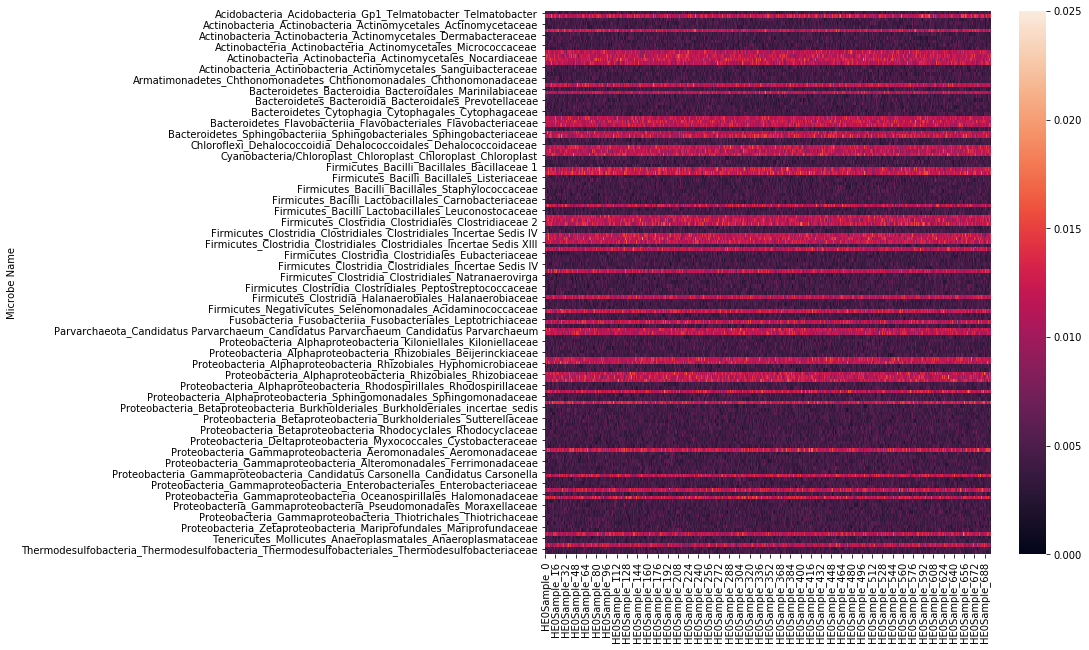

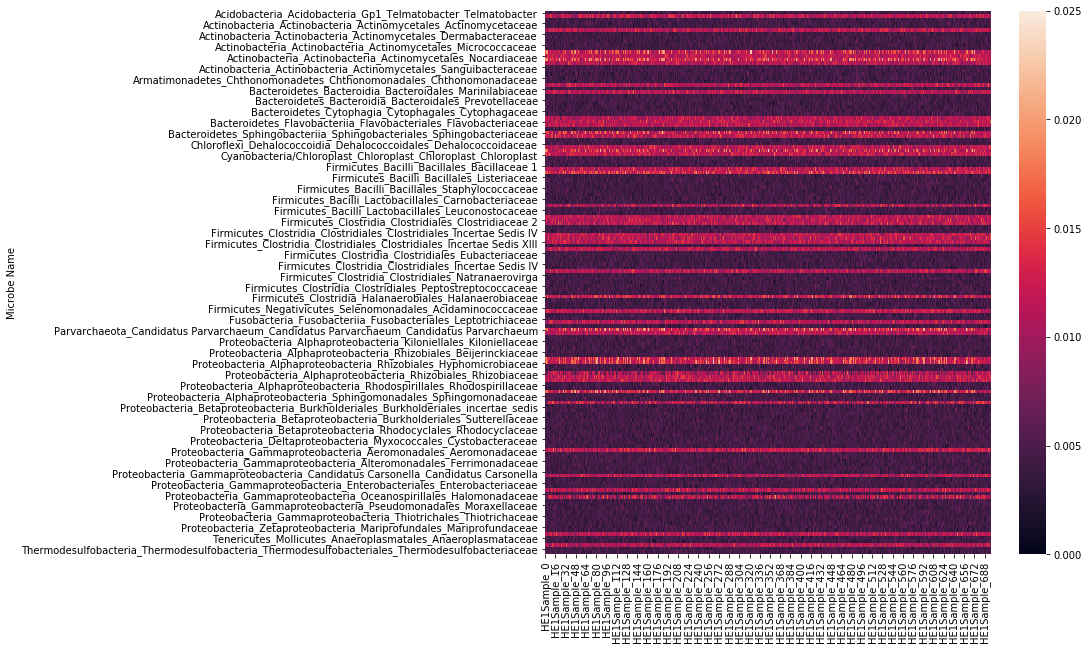

In [14]:
plt.figure(figsize = (10,10))
sns.heatmap(df_he0.set_index('Microbe Name'), vmin = 0, vmax = 0.025)
plt.show()

plt.figure(figsize = (10,10))
sns.heatmap(df_he1.set_index('Microbe Name'), vmin = 0, vmax = 0.025)
plt.show()

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [15]:
#Contingency check to make sure the microbes are the same and in the same order
df_he0['Microbe Name'].tolist() == df_he1['Microbe Name'].tolist()

True

In [16]:
pvalue_dict = {}
for i in range(len(df_he0)):
    microbe = df_he0.loc[i,'Microbe Name']
    he0 = df_he0.loc[i].tolist()[1:]
    he1 = df_he1.loc[i].tolist()[1:]
    _, p = st.ks_2samp(he0, he1)
    pvalue_dict[microbe] = p

### b. Null Hypothesis of the KS Test in our Context

$H_0$ for the KS Test is that the 2 samples tested are drawn from the same underlying distribution. In our context, it can be interpreted as no significantly altered expression of a particular microbe in the stool samples from HE0 and HE1 patients.

Example of a particular microbe...

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [17]:
count_dict = {}
count_dict['0.1'] = sum(1 for i in pvalue_dict.values() if i < 0.1)
count_dict['0.05'] = sum(1 for i in pvalue_dict.values() if i < 0.05)
count_dict['0.01'] = sum(1 for i in pvalue_dict.values() if i < 0.01)
count_dict['0.005'] = sum(1 for i in pvalue_dict.values() if i < 0.005)
count_dict['0.001'] = sum(1 for i in pvalue_dict.values() if i < 0.001)
count_dict

{'0.1': 50, '0.05': 37, '0.01': 27, '0.005': 26, '0.001': 21}

## 2. Multiple Testing

### a. P-value

P-value, in general, is the probability of observing the test statistic or a more extreme value **assuming $H_0$ is true**.

In our context, a p-value of 0.05 represents a 5% probability of observing the KS test statistic, given that there is no significantly altered expression of the microbe in the HE0 and HE1 samples.

### b. P-value Distribution

If the null hypothesis is true, the p-values will follow a **unifom distribution**. The reason is how we define $\alpha$ as the probability of erroneously rejecting $H_0$. We reject $H_0$ when p-value < $\alpha$ and the only way this holds for any value of $\alpha$ is when p is uniformly distributed.

### c. Expected Number of Significant p-values

If no microbe's abundance was altered, which is to say that $H_0$ is true, the significant p-values will be uniformly distributed. Thus, for an $\alpha$ value of 0.1, we expect to see 10% of the total number of samples (and so on).

(We round the number of microbes to 150 instead of 149 here)

| Alpha Level | # of Significant p-values if $H_0$ true | # observed from data in Task 2.1.c |
| --- | --- | --- |
| 0.1 | 15 | 50 |
| 0.05 | 8 | 37 |
| 0.01 | 2 | 27 |
| 0.005 | 1 | 26 |
| 0.001 | 0 | 21 |

### d. Q-Q plot of p-values

#### i. 

In [18]:
#Sample N p-values from a uniform distribution (N = 149)
expected_pvalues = np.random.uniform(0,1,149).tolist()
observed_pvalues = list(pvalue_dict.values())

#### ii. 

In [19]:
expected_log = -np.log10(expected_pvalues)
observed_log = -np.log10(observed_pvalues)

#### iii. 

In [20]:
expected_log = np.sort(expected_log)
observed_log = np.sort(observed_log)

#### iv. v. and vi.

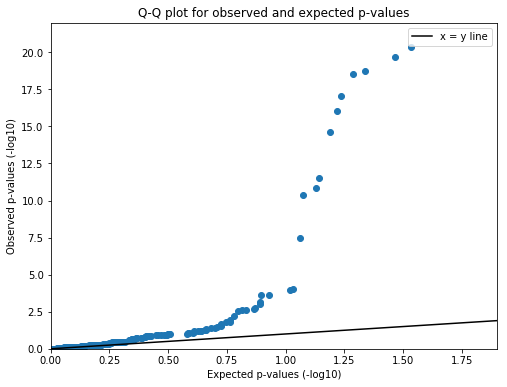

In [21]:
plt.figure(figsize = (8,6))
plt.scatter(expected_log, observed_log)
plt.title('Q-Q plot for observed and expected p-values')
plt.xlabel('Expected p-values (-log10)')
plt.ylabel('Observed p-values (-log10)')
plt.xlim([0,1.9])
plt.ylim([0,22])
#plot x = y line
#plot the limits against each other
plt.plot([0,22],[0,22], label = 'x = y line', color = 'black')
plt.legend()

plt.show()

### e. Follow-up Questions

#### i. How does taking the -log10() of the p-values help you visualize the p-value distribution?

Function -log10 blows up the p-values closer to 0. For example -log(0.001) = 3 and -log(0.01) = 2. Data above 0.1 is less emphasized. This helps us focus more on the lowe numerical values of p_value which are critical when making decision on elimination of H0

#### ii. What can you conclude from the Q-Q plot?


Q-Q doesn't align with the x=y line hence the distributions are quite different, we can say expected and observed p-values follow different distributions. Assumption H0 = True is probably false. There is a difference between HE0 and HE1 samples and this difference is explained

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

In [22]:
#We use the sklearn.decomposition.PCA package and set the svd_solver to "full". No need to separatel center data.
he0_for_pca = df_he0.iloc[:,1:].values.transpose()
he1_for_pca = df_he1.iloc[:,1:].values.transpose()

pca_he0 = PCA(svd_solver = 'full').fit(he0_for_pca)
pca_he1 = PCA(svd_solver = 'full').fit(he1_for_pca)


### b. Ordering Components

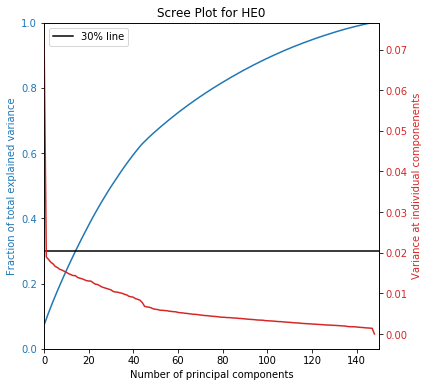

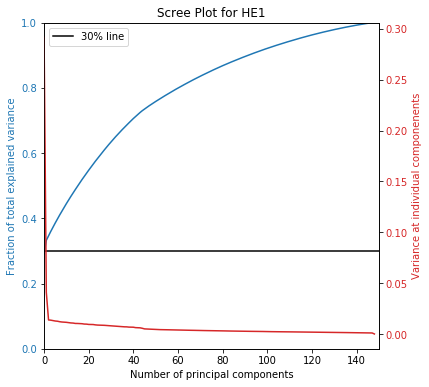

To explain 30% variance
16 components are needed for HE0
2 components are needed for HE1


In [23]:
#components are already ordered in decreasing order. Plot screeplot of the explained variance.
fig, ax1 = plt.subplots(figsize = (6,6))
ax1 = plt.gca()
ax1.plot(np.cumsum(pca_he0.explained_variance_ratio_), color = 'tab:blue')
plt.title('Scree Plot for HE0')
ax1.set_xlabel('Number of principal components')
ax1.set_ylabel('Fraction of total explained variance', color = 'tab:blue')
ax1.set_xlim([0,150])
ax1.set_ylim([0,1])
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0.3, label = '30% line', color = 'black')

ax2 = ax1.twinx()
ax2.plot(pca_he0.explained_variance_ratio_, color = 'tab:red')
ax2.set_ylabel('Variance at individual componenents', color = 'tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.legend()
plt.show()

###############################################

fig, ax1 = plt.subplots(figsize = (6,6))
ax1 = plt.gca()
ax1.plot(np.cumsum(pca_he1.explained_variance_ratio_), color = 'tab:blue')
plt.title('Scree Plot for HE1')
ax1.set_xlabel('Number of principal components')
ax1.set_ylabel('Fraction of total explained variance', color = 'tab:blue')
ax1.set_xlim([0,150])
ax1.set_ylim([0,1])
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0.3, label = '30% line', color = 'black')

ax2 = ax1.twinx()
ax2.plot(pca_he1.explained_variance_ratio_, color = 'tab:red')
ax2.set_ylabel('Variance at individual componenents', color = 'tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax1.legend()
plt.show()


he0_30 = next(x for x, val in enumerate(np.cumsum(pca_he0.explained_variance_ratio_)) if val > 0.3) + 1
he1_30 = next(x for x, val in enumerate(np.cumsum(pca_he1.explained_variance_ratio_)) if val > 0.3) + 1
print('To explain 30% variance\n{} components are needed for HE0\n{} components are needed for HE1'.format(he0_30,he1_30))

### c. Scatter Plot of Microbe Abundance

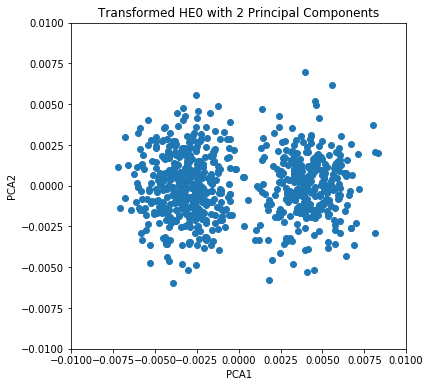

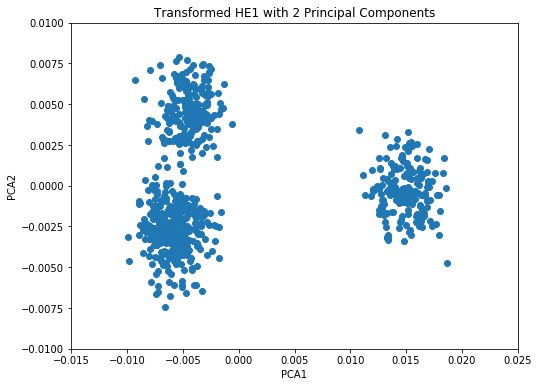

In [24]:
transformed_he0_2comp = PCA(svd_solver = 'full', n_components = 2).fit_transform(he0_for_pca)
transformed_he1_2comp = PCA(svd_solver = 'full', n_components = 2).fit_transform(he1_for_pca)

plt.figure(figsize = (6,6))
plt.scatter(transformed_he0_2comp[:,0], transformed_he0_2comp[:,1])
plt.title('Transformed HE0 with 2 Principal Components')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.01,0.01])
plt.ylim([-0.01,0.01])
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(transformed_he1_2comp[:,0], transformed_he1_2comp[:,1])
plt.title('Transformed HE1 with 2 Principal Components')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.015,0.025])
plt.ylim([-0.01,0.01])
plt.show()

Observations:

We see that clusters begin to form when the first 2 principal components are plotted. We see 2 distinct clusters for HE0 data and 3 distinct clusters for HE1 data. It is also important to note that the first 2 PCs explain only 9% of the total variance for HE0 while they explain 33% of the total variance for HE1 data.

## 2. t-Distributed Stochastic Neighbor Embedding (t-SNE)

### a. Performing t-SNE

Random State = 42

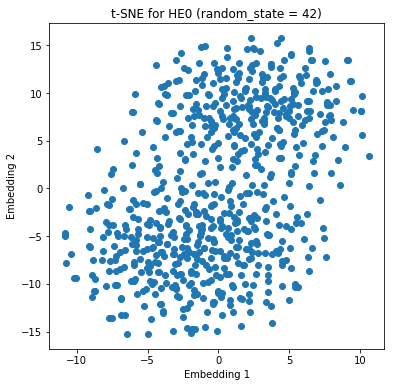

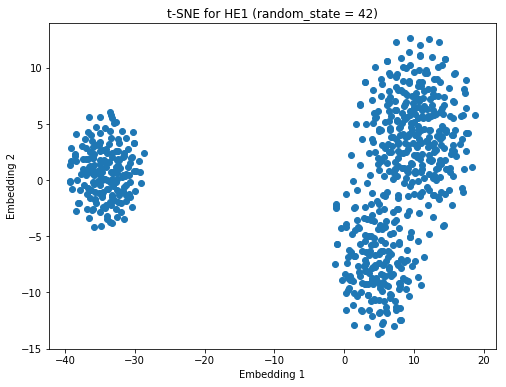

In [25]:
transformed_he0_TSNE = TSNE(n_components = 2, random_state = 42).fit_transform(he0_for_pca)
transformed_he1_TSNE = TSNE(n_components = 2, random_state = 42).fit_transform(he1_for_pca)

plt.figure(figsize = (6,6))
plt.scatter(transformed_he0_TSNE[:,0], transformed_he0_TSNE[:,1])
plt.title('t-SNE for HE0 (random_state = 42)')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
#plt.xlim([-0.01,0.01])
#plt.ylim([-0.01,0.01])
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(transformed_he1_TSNE[:,0], transformed_he1_TSNE[:,1])
plt.title('t-SNE for HE1 (random_state = 42)')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
#plt.xlim([-0.015,0.025])
#plt.ylim([-0.01,0.01])
plt.show()

Random State = 62

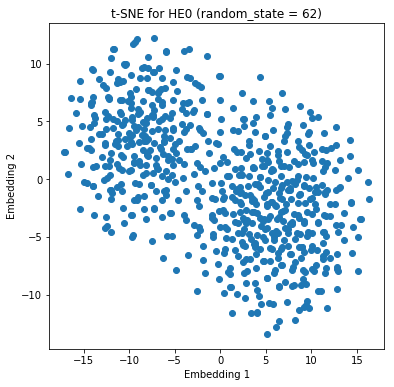

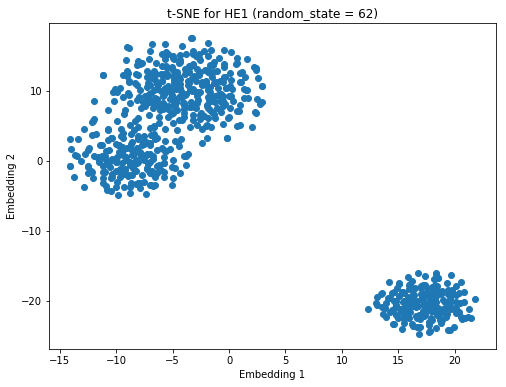

In [26]:
transformed_he0_TSNE = TSNE(n_components = 2, random_state = 62).fit_transform(he0_for_pca)
transformed_he1_TSNE = TSNE(n_components = 2, random_state = 62).fit_transform(he1_for_pca)

plt.figure(figsize = (6,6))
plt.scatter(transformed_he0_TSNE[:,0], transformed_he0_TSNE[:,1])
plt.title('t-SNE for HE0 (random_state = 62)')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
#plt.xlim([-0.01,0.01])
#plt.ylim([-0.01,0.01])
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(transformed_he1_TSNE[:,0], transformed_he1_TSNE[:,1])
plt.title('t-SNE for HE1 (random_state = 62)')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
#plt.xlim([-0.015,0.025])
#plt.ylim([-0.01,0.01])
plt.show()

Random State = 82

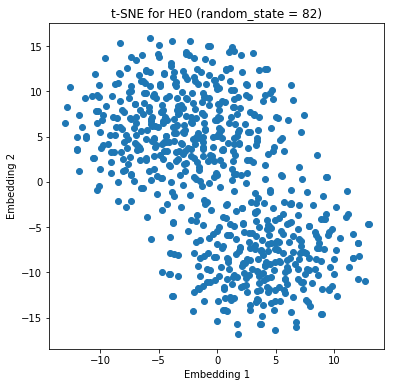

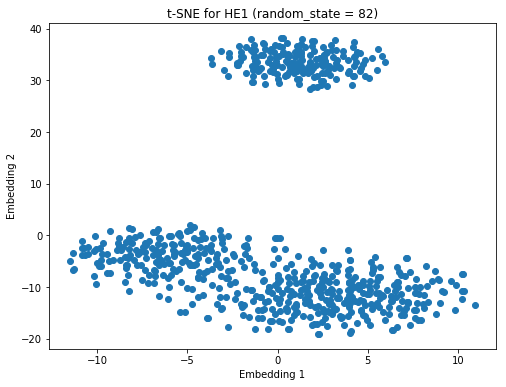

In [27]:
transformed_he0_TSNE = TSNE(n_components = 2, random_state = 82).fit_transform(he0_for_pca)
transformed_he1_TSNE = TSNE(n_components = 2, random_state = 82).fit_transform(he1_for_pca)

plt.figure(figsize = (6,6))
plt.scatter(transformed_he0_TSNE[:,0], transformed_he0_TSNE[:,1])
plt.title('t-SNE for HE0 (random_state = 82)')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
#plt.xlim([-0.01,0.01])
#plt.ylim([-0.01,0.01])
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(transformed_he1_TSNE[:,0], transformed_he1_TSNE[:,1])
plt.title('t-SNE for HE1 (random_state = 82)')
plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
#plt.xlim([-0.015,0.025])
#plt.ylim([-0.01,0.01])
plt.show()

### b. Comparing with PCA

As seen, t-SNE is susceptible to how the random state is initialized. Further, comparing runtimes we see that t-SNE is significantly slower than PCA. The scikit-learn readme also suggests using PCA over t-SNE when the features exceed 50 in number. We're better off using PCA for our analysis.

## 3. Clustering

### a. K-Means

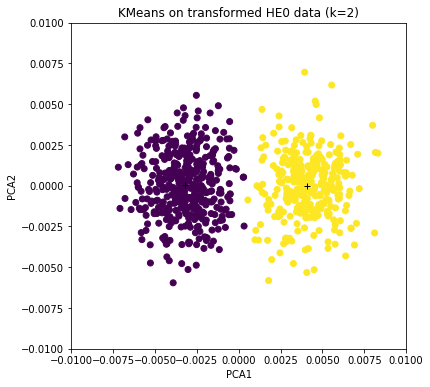

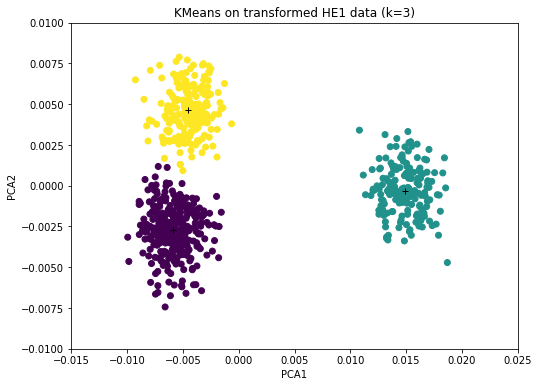

In [28]:
kmeans_he0 = KMeans(n_clusters=2, random_state=0).fit_predict(transformed_he0_2comp)
centers_he0 = KMeans(n_clusters=2, random_state=0).fit(transformed_he0_2comp).cluster_centers_
plt.figure(figsize = (6,6))
plt.scatter(transformed_he0_2comp[:,0], transformed_he0_2comp[:,1], c = kmeans_he0)
plt.plot(centers_he0[0,0],centers_he0[0,1],'+', color = 'black')
plt.plot(centers_he0[1,0],centers_he0[1,1],'+', color = 'black')
plt.title('KMeans on transformed HE0 data (k=2)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.01,0.01])
plt.ylim([-0.01,0.01])
plt.show()

kmeans_he1 = KMeans(n_clusters=3, random_state=0).fit_predict(transformed_he1_2comp)
centers_he1 = KMeans(n_clusters=3, random_state=0).fit(transformed_he1_2comp).cluster_centers_
plt.figure(figsize = (8,6))
plt.scatter(transformed_he1_2comp[:,0], transformed_he1_2comp[:,1], c = kmeans_he1)
plt.plot(centers_he1[0,0],centers_he1[0,1],'+', color = 'black')
plt.plot(centers_he1[1,0],centers_he1[1,1],'+', color = 'black')
plt.plot(centers_he1[2,0],centers_he1[2,1],'+', color = 'black')
plt.title('KMeans on transformed HE1 data (k=3)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.015,0.025])
plt.ylim([-0.01,0.01])
plt.show()

### b. GMM

In [29]:
"""Plotting GMMS nicely
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
"""
import itertools
from scipy import linalg
import matplotlib as mpl

def plot_results(X, Y_, means, covariances, title, plotsize):
    if plotsize == 6:
        color_iter = itertools.cycle(['tab:purple','tab:orange'])
    else:
        color_iter = itertools.cycle(['tab:purple','tab:green','tab:orange'])

    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[:,0], X[:,1], c = Y_, label = 'Cluster '+ str(i), s = 50)
        plt.plot(means[i,0],means[i,1],'+', color = 'black')

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlabel ('PCA1')
    plt.ylabel ('PCA2')
    if plotsize == 6:
        plt.xlim([-0.01,0.01])
        plt.ylim([-0.01,0.01])
    else:
        plt.xlim([-0.015,0.025])
        plt.ylim([-0.01,0.01])
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(plotsize,6)
    plt.title(title)
    plt.show()

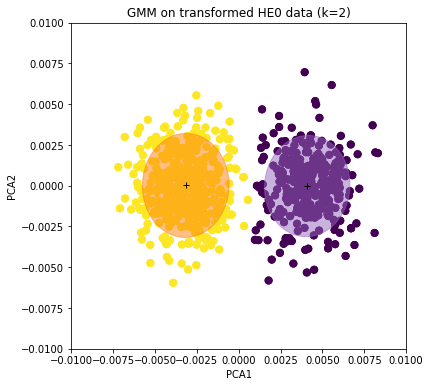

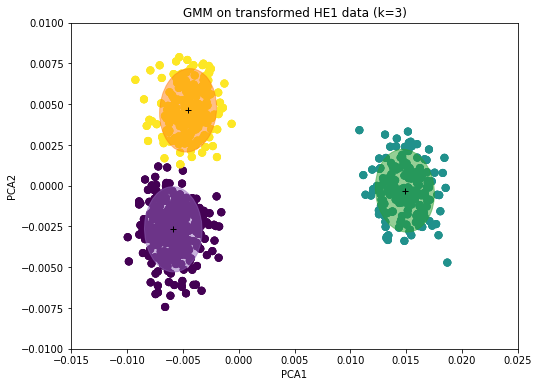

In [30]:
gmm_he0 = GMM(n_components=2).fit(transformed_he0_2comp)
plot_results(transformed_he0_2comp, gmm_he0.predict(transformed_he0_2comp), gmm_he0.means_, gmm_he0.covariances_,
                 'GMM on transformed HE0 data (k=2)',6)

gmm_he1 = GMM(n_components=3).fit(transformed_he1_2comp)
plot_results(transformed_he1_2comp, gmm_he1.predict(transformed_he1_2comp), gmm_he1.means_, gmm_he1.covariances_,
                 'GMM on transformed HE1 data (k=3)',8)

### c. Single and Complete Linkage Hierarchical

Single Linkage Heirarchical

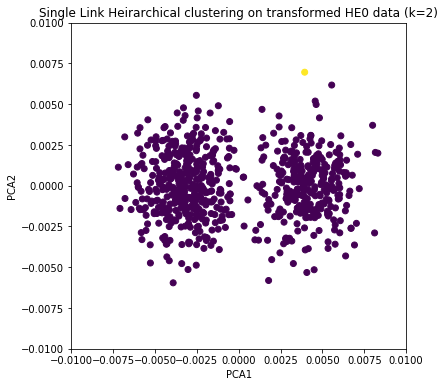

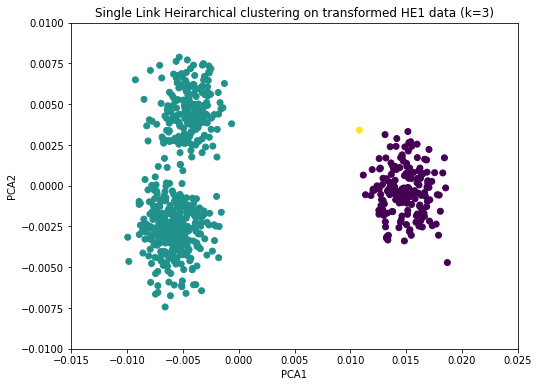

In [31]:
heirarchical_single_he0 = AggClustering(n_clusters=2,linkage='single').fit_predict(transformed_he0_2comp)
plt.figure(figsize = (6,6))
plt.scatter(transformed_he0_2comp[:,0], transformed_he0_2comp[:,1], c = heirarchical_single_he0)
plt.title('Single Link Heirarchical clustering on transformed HE0 data (k=2)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.01,0.01])
plt.ylim([-0.01,0.01])
plt.show()

heirarchical_single_he1 = AggClustering(n_clusters=3,linkage='single').fit_predict(transformed_he1_2comp)
plt.figure(figsize = (8,6))
plt.scatter(transformed_he1_2comp[:,0], transformed_he1_2comp[:,1], c = heirarchical_single_he1)
plt.title('Single Link Heirarchical clustering on transformed HE1 data (k=3)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.015,0.025])
plt.ylim([-0.01,0.01])
plt.show()

Complete Link Heirarchical

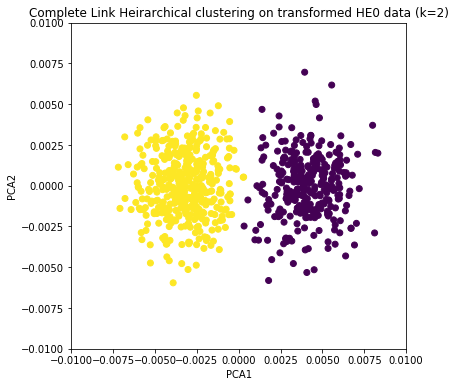

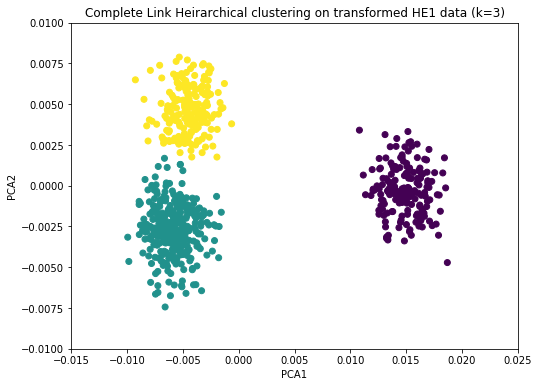

In [32]:
heirarchical_complete_he0 = AggClustering(n_clusters=2,linkage='complete').fit_predict(transformed_he0_2comp)
plt.figure(figsize = (6,6))
plt.scatter(transformed_he0_2comp[:,0], transformed_he0_2comp[:,1], c = heirarchical_complete_he0)
plt.title('Complete Link Heirarchical clustering on transformed HE0 data (k=2)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.01,0.01])
plt.ylim([-0.01,0.01])
plt.show()

heirarchical_complete_he1 = AggClustering(n_clusters=3,linkage='complete').fit_predict(transformed_he1_2comp)
plt.figure(figsize = (8,6))
plt.scatter(transformed_he1_2comp[:,0], transformed_he1_2comp[:,1], c = heirarchical_complete_he1)
plt.title('Complete Link Heirarchical clustering on transformed HE1 data (k=3)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim([-0.015,0.025])
plt.ylim([-0.01,0.01])
plt.show()

### d. Single vs Complete Link Hierarchical Clustering

We see the typical problem of outlier sensitivity for single link clustering. The outlier in each case (HE0 and HE1) forms its own cluster.

The complete link clustering performs much better than the single link clustering (evidently) and we see very clean partitions for both HE0 and HE1 cases. There is no problem with outliers in complete link clustering.

### e. Comparing Clustering Techniques

First, we see that K-Means, GMM and Complete-Link Heirarchical clustering all perform well, clearly forming 2 clusters for HE0 and 3 clusters for HE1. Single-Link Heirarchical clustering succumbs to outliers and gives single-point clusters.

Further, we see that centroids of K-Means and the means of GMM are very close. This can be atributed to the fact that the clusters are very apparent, with little to no intermixing. Thus, we may say that we prefer K-Means over GMM due to its simplicity and speed.

Upon close examination, the only difference we see between K-Means, GMM and Complete-Link Heirarchical clustering is the points lying at inter-cluster boundaries. Each algorithm separates these points differently, which has to do with the clustering approach (hard or soft clustering).

### f. What do Clusters Represent

The clusters here represent patterns which are observed after performing PCA on a large dataset. **In our context, the clusters represent groups of samples within HE0 or HE1 which are "closely related" based on a certain linear combination of their microbe relative abundances.**

What are some factors causing this type of clustering pattern?

One possibility is the dependence on the way in which these samples are collected (I checked, it doesn't depend on that). Other possibility is some other condition (say condition X) that follows with liver cirrhosis in a particular number of samples (like HE). 

### g. Deciding on Number of Clusters

Foremost, we are visualizing data only for the the first two principal components. Foe HE1 dataset, this explains more than 30% variance in the data and we may be quite accurate. However, in the HE0 dataset, we're only explaining ~ 10% of the total variance and thus the 2 clusters we partition data into may not be accurate. This is to say that it may cause loss of information.

Secondly, if the clusters are being formed due to some external factor after the samples are being taken (for instance change in some microbe abundance when the sample comes in contact with atmosphere), the clusters may tend to be inaccurate.

To explore this further, we performed a visualization with 3 PCs and performed clustering with K-Means in 3D. See below for results.

**What does this tell us (if anything lol) ??**

One observation: the data is visually more scattered in the HE0 case, which may have conveniently (and inaccurately) clustered in 2D. Contrarily, the HE1 case still has 3 distinct clusters easily distinguishable.
Performing K-Means on the 3PCA HE0 data makes us question if we need 2 clusters indeed? Or the entire data is one single cluster?

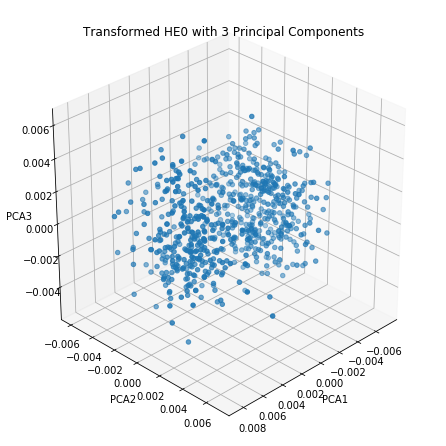

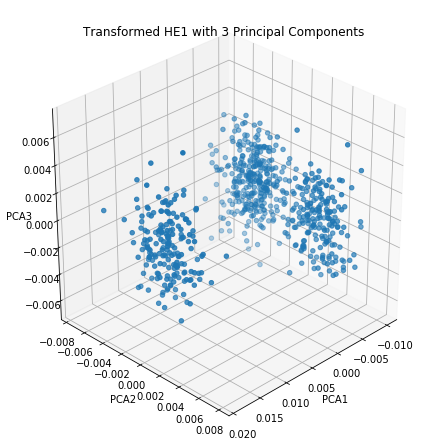

In [33]:
pca_he0_new = PCA(svd_solver = 'full').fit(he0_for_pca)
transformed_he0_3comp = PCA(svd_solver = 'full', n_components = 3).fit_transform(he0_for_pca)
fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)
ax.scatter3D(transformed_he0_3comp[:,0], transformed_he0_3comp[:,1], transformed_he0_3comp[:,2])
plt.title('Transformed HE0 with 3 Principal Components')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.view_init(30,45)
plt.show()


pca_he1_new = PCA(svd_solver = 'full').fit(he1_for_pca)
transformed_he1_3comp = PCA(svd_solver = 'full', n_components = 3).fit_transform(he1_for_pca)
fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)
ax.scatter3D(transformed_he1_3comp[:,0], transformed_he1_3comp[:,1], transformed_he1_3comp[:,2])
plt.title('Transformed HE1 with 3 Principal Components')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.view_init(30,45)
plt.show()

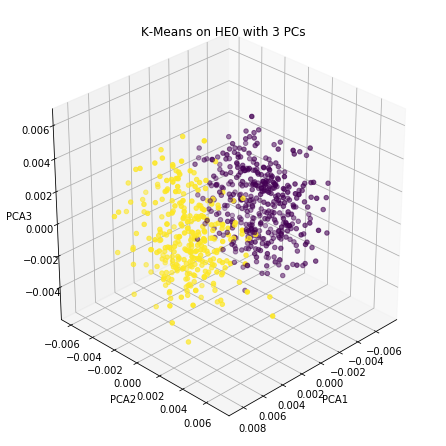

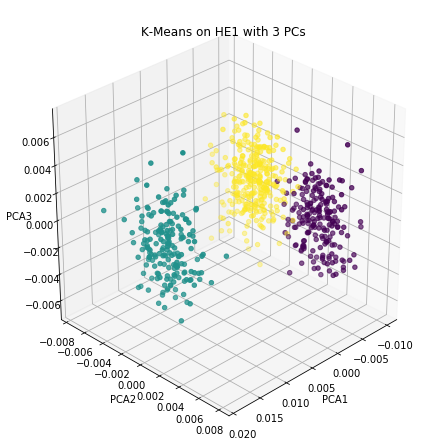

In [34]:
kmeans_he0_new = KMeans(n_clusters=2, random_state=0).fit_predict(transformed_he0_3comp)
centers_he0_new = KMeans(n_clusters=2, random_state=0).fit(transformed_he0_3comp).cluster_centers_

fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)
ax.scatter3D(transformed_he0_3comp[:,0], transformed_he0_3comp[:,1], transformed_he0_3comp[:,2], c = kmeans_he0_new)
plt.title('K-Means on HE0 with 3 PCs')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.view_init(30,45)
plt.show()


kmeans_he1_new = KMeans(n_clusters=3, random_state=0).fit_predict(transformed_he1_3comp)
centers_he1_new = KMeans(n_clusters=3, random_state=0).fit(transformed_he1_3comp).cluster_centers_

fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)
ax.scatter3D(transformed_he1_3comp[:,0], transformed_he1_3comp[:,1], transformed_he1_3comp[:,2], c = kmeans_he1_new)
plt.title('K-Means on HE1 with 3 PCs')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.view_init(30,45)
plt.show()

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

**Analysis Procedure:**

We are comparing the three clusters formed in HE1 with the two clusters formed in HE0. Since it is difficult to compare each individual cluster point, we consider the centers obtained from K-Means to be representative points of their respective clusters.

Step 1: All the cluster centers obtained from K-Means are in the Principal Component Axis coordinates. We note that PCAs of HE0 and HE1 are **not directly comparable**. We thus convert each cluster center from PCA coordinates (PCA1, PCA2) to relative abundance or original coordinates (microbe1, microbe2, microbe3, ..., microbe149).

Step 2: Compare the relative abundances of the cluster centers of HE0 with HE1. See if 2 clusters of HE0 and HE1 match and one cluster from HE1 stands out. We do this with a plot shown below.

Step 3: From Step 2, identify the microbes with significantly affected relative abundances.

In [134]:
he0_center = np.array(df_he0.iloc[:,1:].apply(np.mean,axis = 1)).reshape(149,1)
he1_center = np.array(df_he1.iloc[:,1:].apply(np.mean,axis = 1)).reshape(149,1)

he0_center = np.append(he0_center,he0_center,axis = 1)
temp = he1_center
he1_center = np.append(he1_center,he1_center, axis = 1)
he1_center = np.append(he1_center,temp, axis = 1)

#Note that we're using all 149 components here for the KMeans cluster center,
#then obtaining relative abundances using matrix multiplication

transformed_he0 = PCA(svd_solver = 'full').fit_transform(he0_for_pca)
centers_he0_all_PCA = KMeans(n_clusters = 2, random_state = 0).fit(transformed_he0).cluster_centers_
rel_abundance_he0 = he0_center + np.matmul(np.linalg.inv(pca_he0.components_), centers_he0_all_PCA.transpose())

transformed_he1 = PCA(svd_solver = 'full').fit_transform(he1_for_pca)
centers_he1_all_PCA = KMeans(n_clusters = 3, random_state = 0).fit(transformed_he1).cluster_centers_
rel_abundance_he1 = he1_center + np.matmul(np.linalg.inv(pca_he1.components_), centers_he1_all_PCA.transpose())

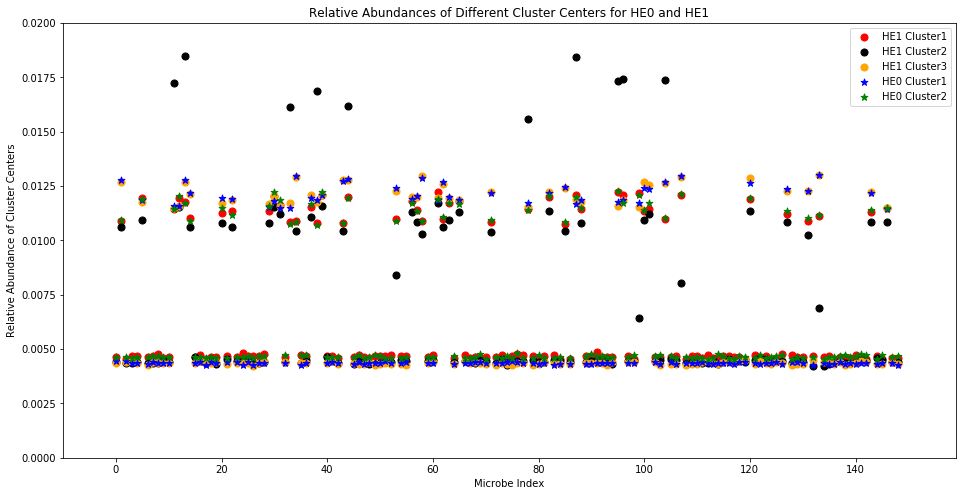

In [152]:
#Now we plot the relative abundances of cluster centers.

plt.figure(figsize = (16,8))
colors = ['red','black','orange','blue','green']
for i in range(3):
    plt.scatter(range(149), rel_abundance_he1[:,i], marker = "o", s = 50, color = colors[i], label = 'HE1 Cluster'+str(i+1))

for i in range(2):
    plt.scatter(range(149), rel_abundance_he0[:,i], marker = "*", s = 50, color = colors[i+3], label = 'HE0 Cluster'+str(i+1))
    
plt.legend()
plt.xlabel('Microbe Index')
plt.ylabel('Relative Abundance of Cluster Centers')
plt.title('Relative Abundances of Different Cluster Centers for HE0 and HE1')
plt.xlim([-10, 159])
plt.ylim([0,0.02])
plt.show()

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

From the plot, it is very clear that:

HE1 Cluster 1 (red) maps to HE0 Cluster 2 (green)

HE1 Cluster 3 (orange) maps to HE0 Cluster 1 (blue)

HE1 Cluster 2 (black) has significantly altered relative abundances

To see which HE0 cluster HE1Cluster2 is most similar to, we use Eucledian Distance Between the centers.

In [154]:
dist_he0_clus1 = np.linalg.norm(rel_abundance_he1[:,1] - rel_abundance_he0[:,0])
print('d(HE1 Cluster 2, HE0 Cluster 1) = {}\n'.format(dist_he0_clus1))

dist_he0_clus2 = np.linalg.norm(rel_abundance_he1[:,1] - rel_abundance_he0[:,1])
print('d(HE1 Cluster 2, HE0 Cluster 2) = {}\n'.format(dist_he0_clus2))

d(HE1 Cluster 2, HE0 Cluster 1) = 0.020891463880822518

d(HE1 Cluster 2, HE0 Cluster 2) = 0.020282666046716382



We see that the cluster with significantly altered microbiome is most related to **HE0 Cluster 2**.

### c. Identify Microbes with Significantly Altered Relative Abundance

In [169]:
he0c2 = df_he0.iloc[:,1:].T.reset_index().iloc[:,1:][pd.Series(kmeans_he0) ==1]
he1c1 = df_he1.iloc[:,1:].T.reset_index().iloc[:,1:][pd.Series(kmeans_he1) ==1]

microbes = []
microbe_number = []
alpha_level = 0.0000025

for i in range(len(df_he0)):
    _, p = st.ks_2samp(he0c2[i], he1c1[i])
    if p < alpha_level:
        microbes.append(df_he0.iloc[i,0])
        microbe_number.append(i)
print('The following microbes have significantly altered abundance')
microbes

The following microbes have significantly altered abundance


['Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae',
 'Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae',
 'Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis',
 'Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae',
 'Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae',
 'Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae',
 'Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI',
 'Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae',
 'Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XIII',
 'Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae',
 'Firmicutes_Negativicutes_Selenomonadales_Veillonellaceae',
 'Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum',
 'Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae',
 'Proteobacteria_Alphaproteobacteria_Rhizobiales_H

To Cross Check if the visually different microbes (scattered black dots in the previous plot) match with the microbes we identified using the KS-Test, we plot the following:

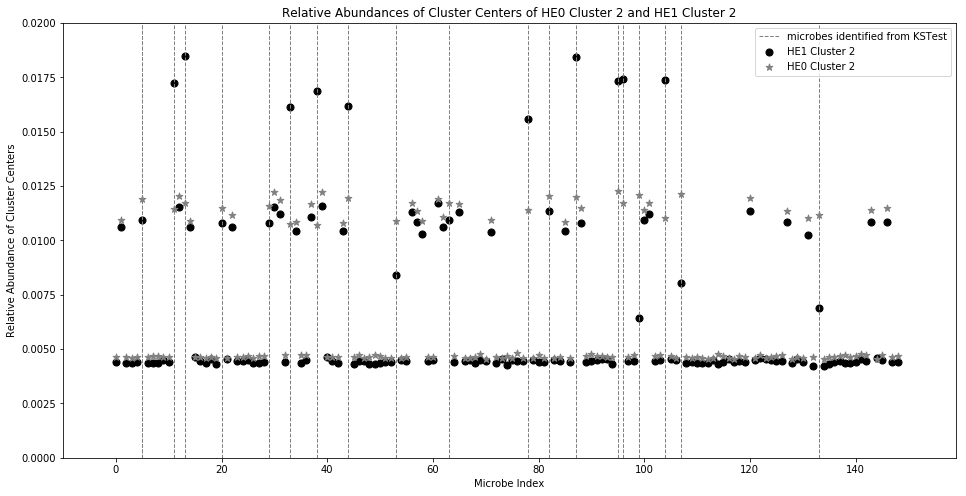

In [180]:
plt.figure(figsize = (16,8))
colors = ['red','black','orange','blue','green']
plt.scatter(range(149), rel_abundance_he1[:,1], marker = "o", s = 50, color = 'black', label = 'HE1 Cluster 2')
plt.scatter(range(149), rel_abundance_he0[:,1], marker = "*", s = 50, color = 'gray', label = 'HE0 Cluster 2')
plt.axvline(microbe_number[0], 0, 1, ls = '--', color = 'gray', lw = 1, label = 'microbes identified from KSTest')

for number in microbe_number:
    plt.axvline(number, 0, 1, ls = '--', color = 'gray', lw = 1)

plt.legend()
plt.xlabel('Microbe Index')
plt.ylabel('Relative Abundance of Cluster Centers')
plt.title('Relative Abundances of Cluster Centers of HE0 Cluster 2 and HE1 Cluster 2')
plt.xlim([-10, 159])
plt.ylim([0,0.02])
plt.show()

**As clearly seen, all the microbes with significantly altered abundances have been captured!**

(evil laughter)





## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

In [194]:
mean_he0 = df_he0.iloc[:,1:].apply(np.mean,axis = 1)
mean_he1 = df_he1.iloc[:,1:].apply(np.mean,axis = 1)

for number in microbe_number:
    if mean_he0[number] > mean_he1[number]:
        print('Relative Abundance of {} decreased in HE1\n'.format(df_he0.iloc[number,0]))
    else:
        print('Relative Abundance of {} increased in HE1\n'.format(df_he0.iloc[number,0]))

Relative Abundance of Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae decreased in HE1

Relative Abundance of Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae increased in HE1

Relative Abundance of Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae increased in HE1

Relative Abundance of Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis decreased in HE1

Relative Abundance of Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae decreased in HE1

Relative Abundance of Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae increased in HE1

Relative Abundance of Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae increased in HE1

Relative Abundance of Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI increased in HE1

Relative Abundance of Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae decreased in HE1

Relative Abundance of Firmicutes_Clostridia_Clostridiales_Clostridiales_In

### b. Biological Relations